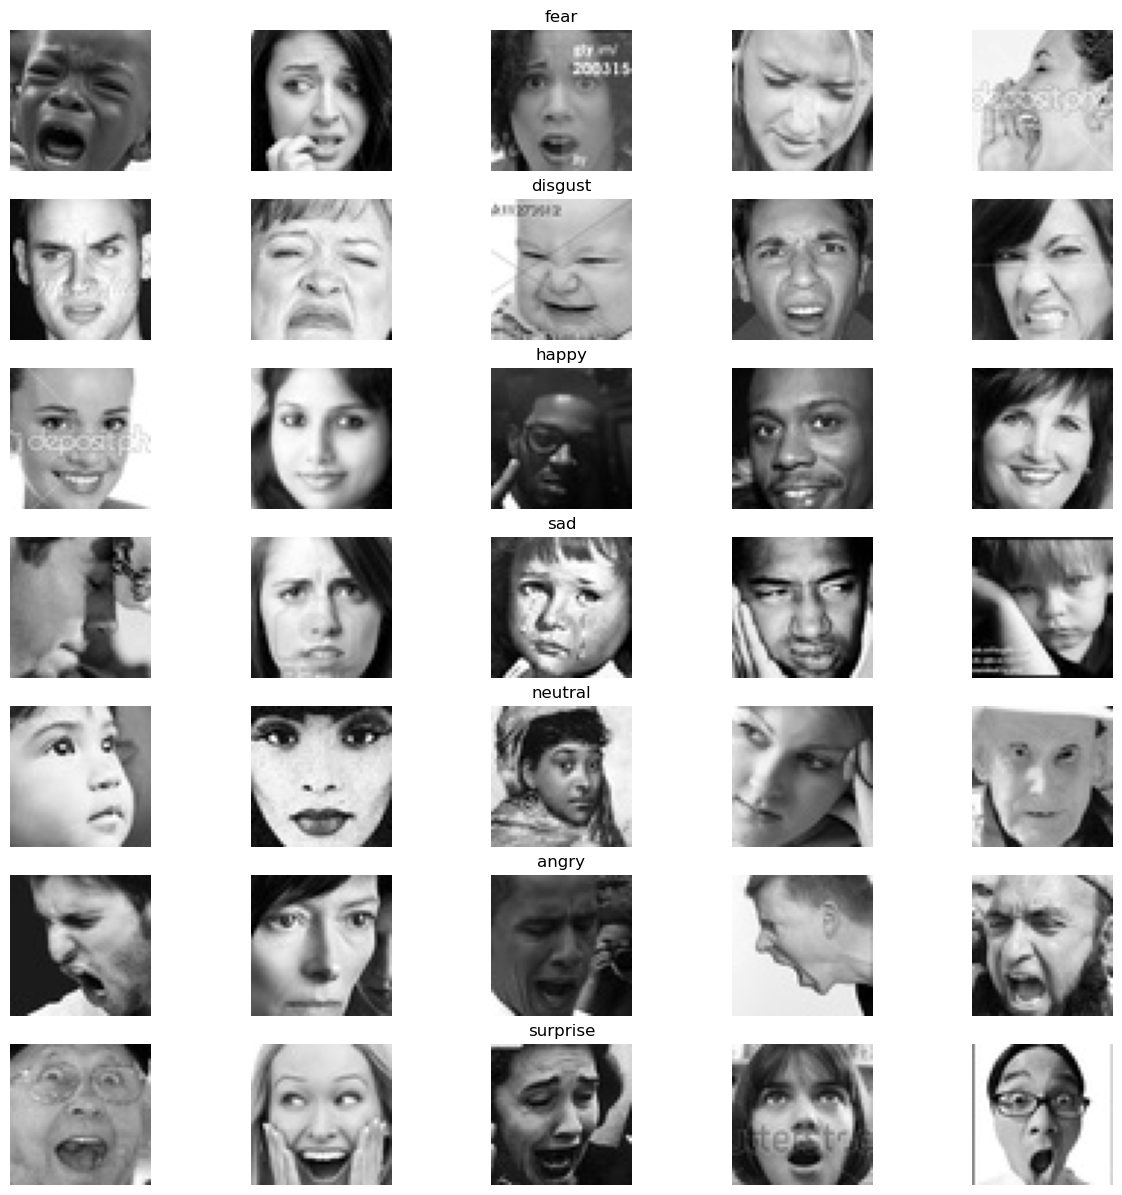

In [1]:
import matplotlib.pyplot as plt
import random
from PIL import Image
import os

train_dir = './train'

emotions = os.listdir(train_dir)

fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(15, 15))

for row, emotion in enumerate(emotions):
    emotion_path = os.path.join(train_dir, emotion)
    emotion_images = os.listdir(emotion_path)

    random_images = random.sample(emotion_images, 5)

    for col, image_file in enumerate(random_images):
        image_path = os.path.join(emotion_path, image_file)

        img = Image.open(image_path)
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].axis('off')  # Turn off the axis numbers
        if col == 2:  # Display the emotion name above the middle image of each row
            axes[row, col].set_title(emotion)

In [2]:
batch_size = 64
target_size = (48, 48)

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    zoom_range=0.1,
    validation_split=0.2
)

datagen_val = ImageDataGenerator(
    rescale=1./255,  
    validation_split=0.2  
)

2023-07-31 19:17:01.488242: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-31 19:17:01.781077: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 19:17:02.738353: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
train_generator = datagen_train.flow_from_directory(
    train_dir, 
    target_size=target_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training' 
)

val_generator = datagen_val.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation'
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the CNN model
model = Sequential([

    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 1)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                        

2023-07-31 19:17:08.721501: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-31 19:17:08.873730: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-31 19:17:08.874070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-31 19:17:08.875263: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-31 19:17:08.875509: I tensorflow/compile

 batch_normalization_4 (Batc  (None, 12, 12, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       147584    
                                                                 
 batch_normalization_5 (Batc  (None, 12, 12, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 6, 6, 128)         0         
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (De

In [6]:
history = model.fit(
    train_generator,
    epochs=50, 
    validation_data=val_generator
)

Epoch 1/50


2023-07-31 19:17:13.519087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-31 19:17:14.703760: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-07-31 19:17:16.628457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-31 19:17:18.249451: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2023-07-31 19:1

  3/359 [..............................] - ETA: 14s - loss: 3.2989 - accuracy: 0.1406  

2023-07-31 19:17:22.381652: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



359/359 [==============================] - ETA: 0s - loss: 2.0813 - accuracy: 0.2473

2023-07-31 19:17:41.335705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


359/359 [==============================] - 31s 61ms/step - loss: 2.0813 - accuracy: 0.2473 - val_loss: 1.9288 - val_accuracy: 0.2498
Epoch 2/50
359/359 [==============================] - 13s 36ms/step - loss: 1.6710 - accuracy: 0.3515 - val_loss: 1.5355 - val_accuracy: 0.4168
Epoch 3/50
359/359 [==============================] - 12s 33ms/step - loss: 1.4782 - accuracy: 0.4244 - val_loss: 1.3194 - val_accuracy: 0.4980
Epoch 4/50
359/359 [==============================] - 13s 35ms/step - loss: 1.3834 - accuracy: 0.4695 - val_loss: 1.2590 - val_accuracy: 0.5132
Epoch 5/50
359/359 [==============================] - 13s 35ms/step - loss: 1.3195 - accuracy: 0.5005 - val_loss: 1.4333 - val_accuracy: 0.4705
Epoch 6/50
359/359 [==============================] - 12s 34ms/step - loss: 1.2830 - accuracy: 0.5116 - val_loss: 1.5522 - val_accuracy: 0.4309
Epoch 7/50
359/359 [==============================] - 13s 37ms/step - loss: 1.2489 - accuracy: 0.5276 - val_loss: 1.2004 - val_accuracy: 0.5417
Epo

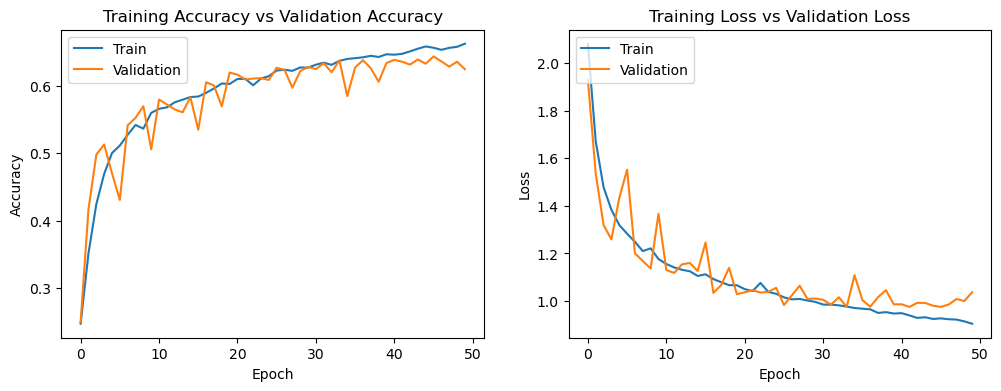

In [7]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [8]:
model.save('emotion_model.h5')